# Insurance Classification

(dataset from Kaggle)

---

The dataset contains the following columns:

* Age: Represents the age of the insured individual.
* Sex: Indicates the gender of the insured individual (male or female).
* BMI: Stands for Body Mass Index, a measure of body fat based on height and weight.
* Children: Denotes the nubmer of children or dependents covered by the insurance policy.
* Smoker: Indicates whether the insured individual is a smoker or non-smoker.
* Region: Represents the geographical region of the insured individual's residence.
* Expenses: Represents the medical expenses incurred by the insured individual.

In [2]:
# We will explore the data and build some classification models to see which works best for predicting the insurance class

# First we will import some packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

### Upload Dataset

In [3]:
# Google Colab file upload formatting

from google.colab import files

uploaded = files.upload()

#Kaggle formatting

#data = pd.read_csv('/kaggle/input/...')

#Juptyer notebook formatting

#data = pd.read_csv('/Users/billypacetti/Desktop/Datasets')

Saving insurance_classification.csv to insurance_classification.csv


In [27]:
# Check that the dataframe uploaded properly and assign to a variable

data = pd.read_csv('insurance_classification.csv')

data.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [6]:
# Get a summary of the dataframe

data.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Columns: 7 entries, age to expenses
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Data Cleaning

In [7]:
# Check the shape of the data

data.shape

(1338, 7)

In [8]:
# Check data types to see if variables are numeric or string

data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
dtype: object

In [9]:
# Check how many unique values are in each column for categorical variables

data.nunique()

age           47
sex            2
bmi          275
children       6
smoker         2
region         4
expenses    1337
dtype: int64

In [10]:
# Check for missing data

data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [21]:
# Check for duplicate data

data.duplicated().sum()

1

In [28]:
# Drop duplicates

data = data.drop_duplicates()

In [17]:
# Check for duplicate data

data.duplicated().sum()

0

In [16]:
# # Separate the categorical variables and print the unique values

categorical_variables = data.select_dtypes(include='O').columns.tolist()

for var in categorical_variables:
  unique_values = data[var].unique()
  print(f'Unique values in {var}: {unique_values}')

Unique values in sex: ['female' 'male']
Unique values in smoker: ['yes' 'no']
Unique values in region: ['southwest' 'southeast' 'northwest' 'northeast']


In [29]:
# One-hot encode the binary categorical variables

binary_variables = ['sex', 'smoker']

data = pd.get_dummies(data, columns=binary_variables, drop_first=True)

cat_var = ['region']

data = pd.get_dummies(data, columns=cat_var)

data.head()

,age,bmi,children,expenses,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,0,1,0,0,0,1
1,18,33.8,1,1725.55,1,0,0,0,1,0
2,28,33.0,3,4449.46,1,0,0,0,1,0
3,33,22.7,0,21984.47,1,0,0,1,0,0
4,32,28.9,0,3866.86,1,0,0,1,0,0


In [30]:
# Check the final shape of data

data.shape

(1337, 10)

## Exploratory Data Analysis

### Summary Statistics

In [19]:
# Get the summary statistics

data.describe()

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.665520,1.095737,13279.121638,0.504862,0.204936,0.242334,0.272251,0.243082
std,14.044333,6.100664,1.205571,12110.359657,0.500163,0.403806,0.428655,0.445285,0.429104
min,18.000000,16.000000,0.000000,1121.870000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.300000,0.000000,4746.340000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,30.400000,1.000000,9386.160000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,34.700000,2.000000,16657.720000,1.000000,0.000000,0.000000,1.000000,0.000000
max,64.000000,53.100000,5.000000,63770.430000,1.000000,1.000000,1.000000,1.000000,1.000000


### Univariate Statistics

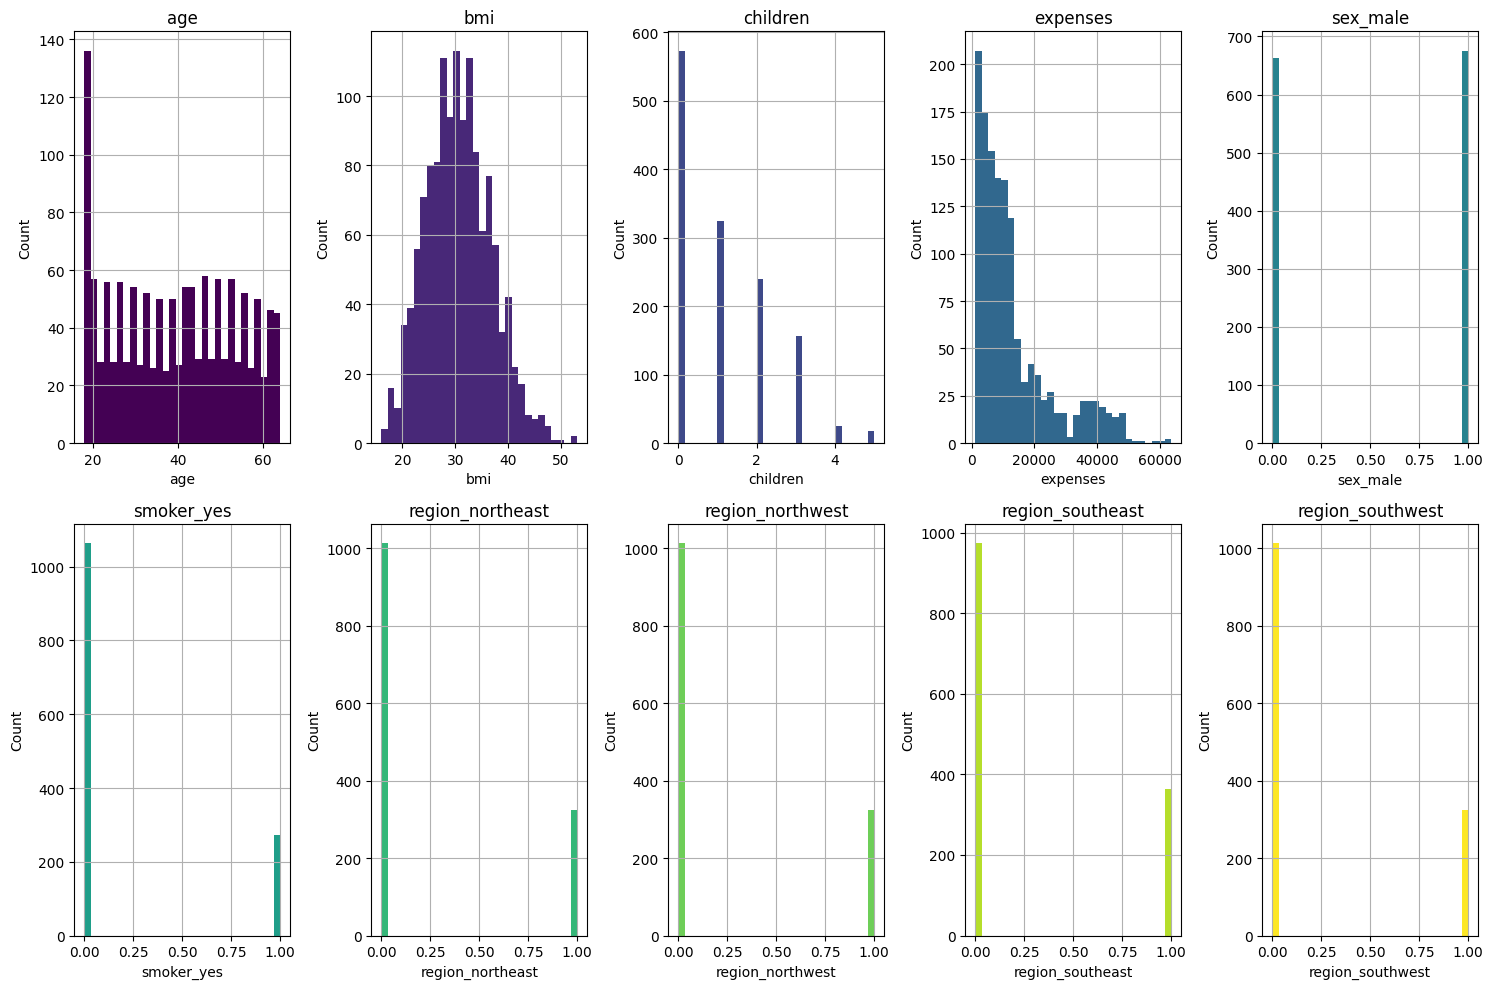

In [31]:
# We will check the frequencies of the variables using histogram charts

# Wrap the charts to 5 per row since there are 10 plots
num_cols = len(data.columns)
plots_per_row = 5
num_rows = (num_cols + plots_per_row - 1) // plots_per_row

# Define the custom colors
colors = plt.cm.viridis(np.linspace(0, 1, num_cols))

# Create the subplots with proper spacing
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 5*num_rows))
fig.subplots_adjust(hspace=0.5) # Adjust the vertical spacing

# Iterate through the columns and plot histograms
for i, (col, color) in enumerate(zip(data.columns, colors)):
  row_index, col_index = divmod(i, plots_per_row)
  ax = axes[row_index, col_index]
  data[col].hist(bins=30, ax=ax, color=color)

  # Set the axis labels and titles
  ax.set_xlabel(col)
  ax.set_ylabel('Count')
  ax.set_title(col)

# Adjust the layout to prevent overlapping titles
plt.tight_layout()
plt.show()

### Bivariate Statistics

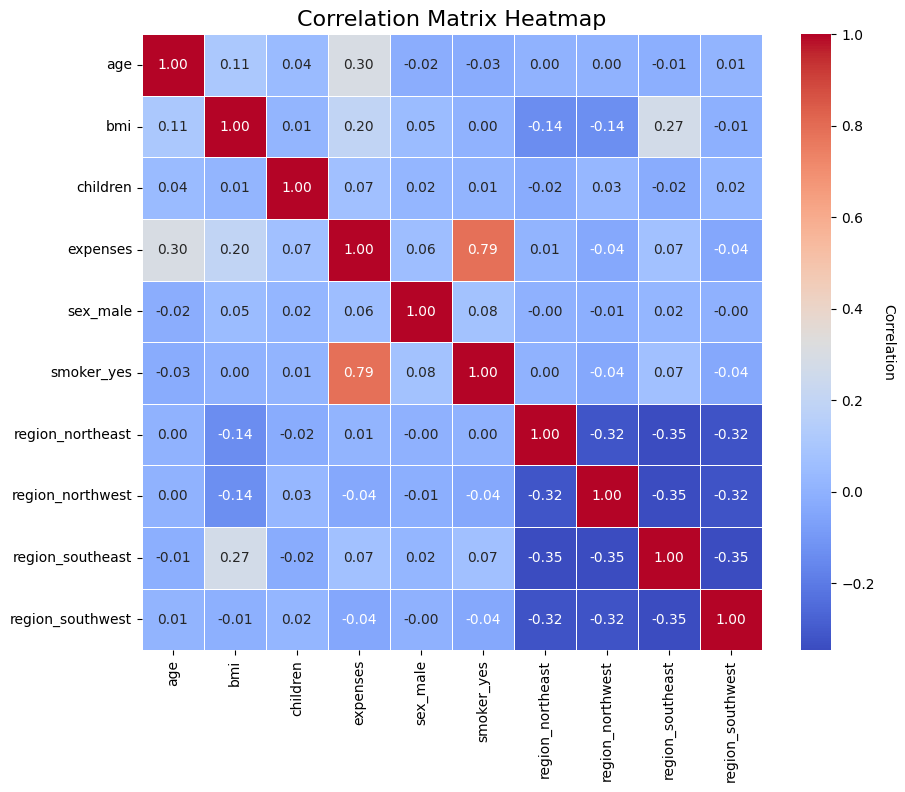

In [32]:
# Calculate correlation matrix

correlation_matrix = data.corr()

# Create a heatmap

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 10})
heatmap.set_title("Correlation Matrix Heatmap", fontsize=16)

# Add a colorbar

cbar = heatmap.collections[0].colorbar
cbar.set_label('Correlation', rotation=270, labelpad=15)

plt.show()

Feature Engineering

In [35]:
# Calculate the median of the 'expenses' column
median_value = data['expenses'].median()

# Classify the variable as 0 or 1
data['expenses'] = (data['expenses'] > median_value).astype(int)

## Data Preprocessing

In [42]:
# Prepare training, and testing datasets

# According to publisher of dataset on Kaggle, Loan_Status is target variable

x = data.drop(['expenses'], axis=1)

x.head()

,age,bmi,children,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.9,0,0,1,0,0,0,1
1,18,33.8,1,1,0,0,0,1,0
2,28,33.0,3,1,0,0,0,1,0
3,33,22.7,0,1,0,0,1,0,0
4,32,28.9,0,1,0,0,1,0,0


In [43]:
# Separate target variable

y = data['expenses']

y.head()

0    1
1    0
2    0
3    1
4    0
Name: expenses, dtype: int64

In [44]:
# Count occurrences of 0 and 1 in the 'Class' column
value_counts = y.value_counts()

# Display the counts
print("Counts of 0 and 1 values:")
print(value_counts)

Counts of 0 and 1 values:
0    669
1    668
Name: expenses, dtype: int64


In [45]:
# Convert pandas dataframe/series to numpy array

x_columns = x.columns # Store the column names

x = x.values

y = y.values

In [46]:
# Split the dataset into training and testing sets

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


print('train:', x_train.shape, x_train.shape)

print('test:', x_test.shape, x_test.shape)

train: (1069, 9) (1069, 9)
test: (268, 9) (268, 9)


In [47]:
# Apply feature normalization to training and test sets to be able to accurately use machine learning methods with them

scaler = MinMaxScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)

x_test=scaler.transform(x_test)

# Classification Modeling

## Logistic Regression

In [48]:
# Build a logistic regression classifer

logreg = LogisticRegression()

# Define the hyperparameter space
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}

# Use GridSearchCV to tune the hyperparameters
grid_search = GridSearchCV(logreg, param_grid, cv=10, scoring='accuracy')  # 10-fold cross-validation

grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

Best parameters: {'C': 0.01, 'penalty': 'l2'}
Best cross-validated score: 0.9036325163110563


In [49]:
# Retrieve the best parameters from the grid search
best_params = grid_search.best_params_

# Create a new logistic regression model with the best parameters
logreg_optimized = LogisticRegression(C=best_params['C'], penalty='l2')

# Fit the model
logreg_optimized.fit(x_train, y_train)

# Predictions on the test data
y_pred_logreg = logreg_optimized.predict(x_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))

Accuracy: 0.9365671641791045
Confusion Matrix:
 [[137   5]
 [ 12 114]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       142
           1       0.96      0.90      0.93       126

    accuracy                           0.94       268
   macro avg       0.94      0.93      0.94       268
weighted avg       0.94      0.94      0.94       268



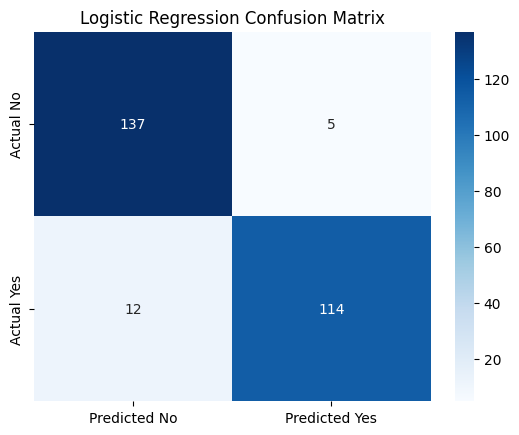

In [50]:
# Visualize the confusion matrix

cm_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.title('Logistic Regression Confusion Matrix')
plt.show()

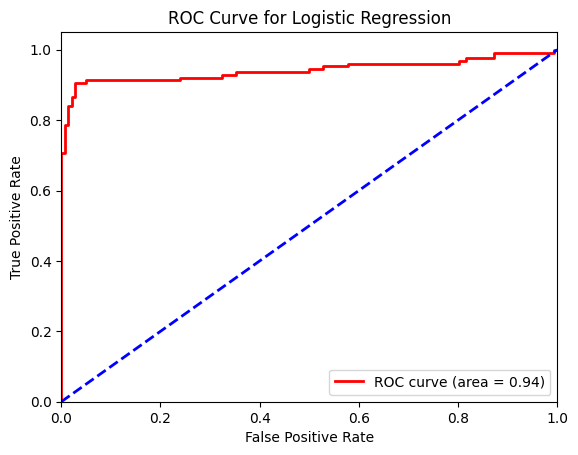

In [51]:
#Visualize the ROC Curve and AUC Score

# Calculate the ROC curve points
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, logreg_optimized.predict_proba(x_test)[:,1])

# Calculate the AUC
roc_auc = auc(fpr_logreg, tpr_logreg)

# Plot the figure
plt.figure()
plt.plot(fpr_logreg, tpr_logreg, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

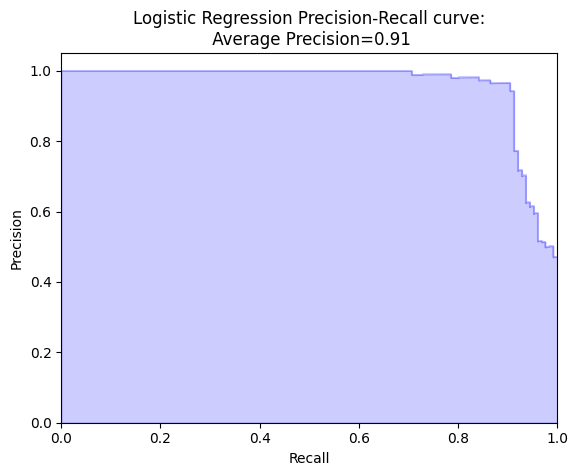

In [52]:
# Visualize the precision-recall curve

precision, recall, _ = precision_recall_curve(y_test, logreg_optimized.predict_proba(x_test)[:,1])
average_precision = average_precision_score(y_test, y_pred_logreg)

# Plot the figure
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Logistic Regression Precision-Recall curve:\n Average Precision={average_precision:.2f}')
plt.show()

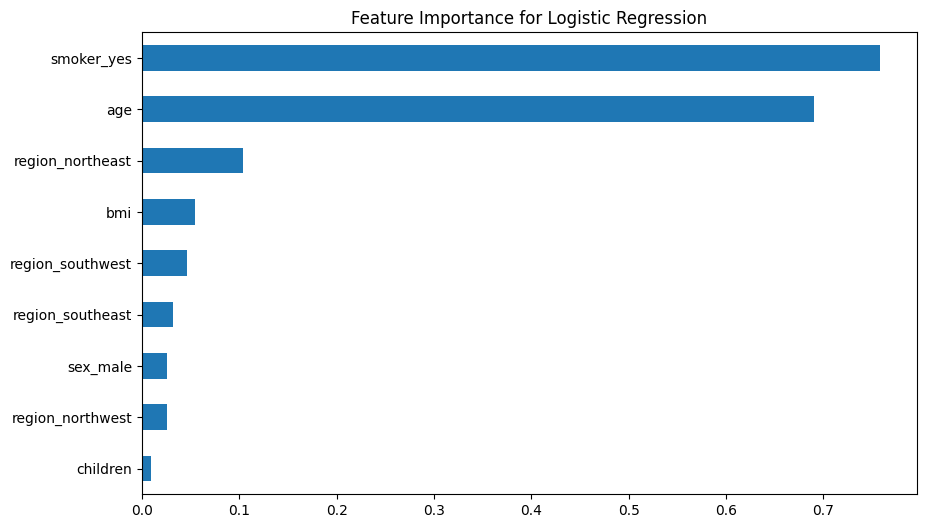

In [53]:
# Visualize the feature importance

feature_importance = pd.Series(index = x_columns, data = np.abs(logreg_optimized.coef_[0]))
feature_importance.nlargest(10).sort_values().plot(kind = 'barh', figsize = (10,6))
plt.title('Feature Importance for Logistic Regression')
plt.show()

## K-Nearest Neighbors Classifier (KNN)

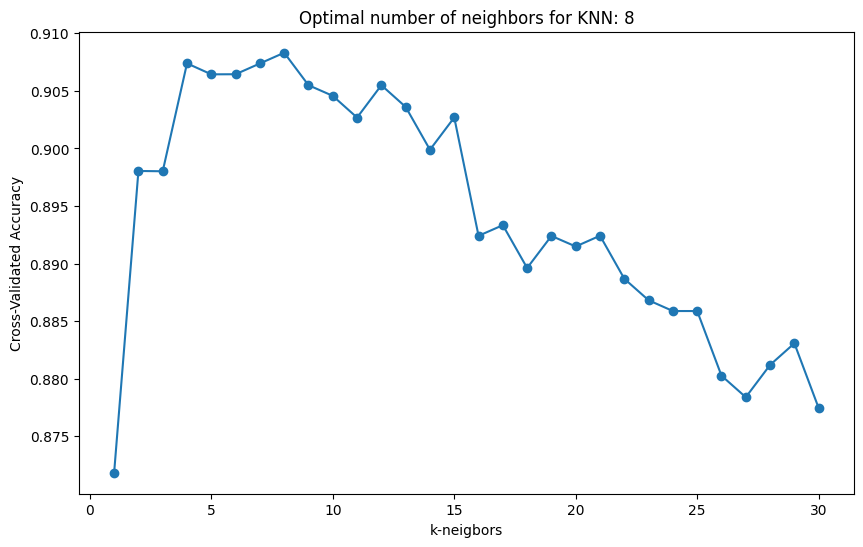

In [54]:
# Build a KNN classifier by tuning the optimal number of neighbors

# Define the range of neighbors to try
neighbor_range = range(1, 31)

# Create a list to store average cross-validation scores
cv_scores = []

# Perform 10-fold cross-validation for each number of neighbors
for n_neighbors in neighbor_range:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')  # 10-fold cross-validation
    cv_scores.append(scores.mean())

# Find the optimal number of neighbors
optimal_neighbors = neighbor_range[np.argmax(cv_scores)]

# Plot the relationship between K and cross-validation accuracy
plt.figure(figsize=(10,6))
plt.plot(neighbor_range, cv_scores, marker='o')
plt.xlabel('k-neigbors')
plt.ylabel('Cross-Validated Accuracy')
plt.title(f'Optimal number of neighbors for KNN: {optimal_neighbors}')
plt.show()

In [55]:
# Initialize and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=optimal_neighbors)
knn.fit(x_train, y_train)

# Make predictions on the test data
y_pred_knn = knn.predict(x_test)

# Evaluate the model
print("KNN Model Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

KNN Model Accuracy: 0.9291044776119403
Confusion Matrix:
 [[137   5]
 [ 14 112]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94       142
           1       0.96      0.89      0.92       126

    accuracy                           0.93       268
   macro avg       0.93      0.93      0.93       268
weighted avg       0.93      0.93      0.93       268



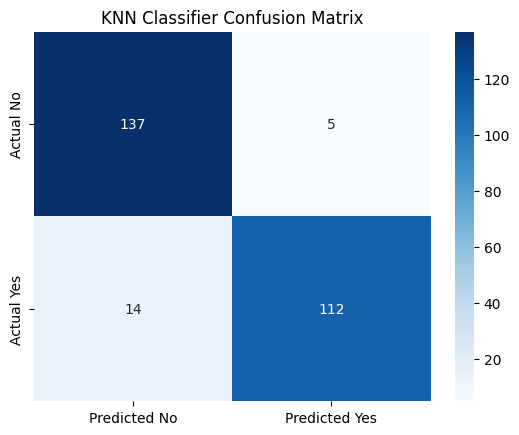

In [56]:
# Visualize the confusion matrix

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.title('KNN Classifier Confusion Matrix')
plt.show()

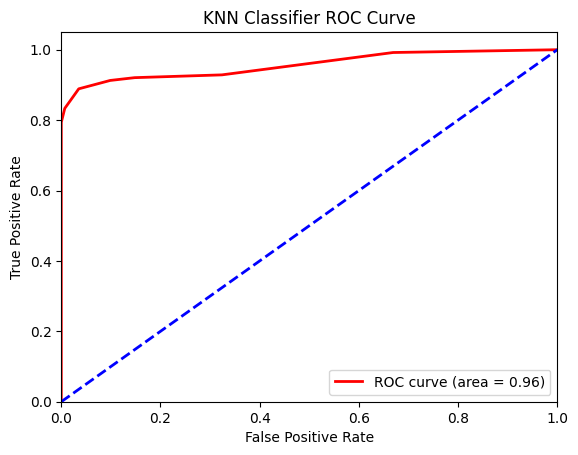

In [57]:
# Visualize the ROC curve and AUC score

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn.predict_proba(x_test)[:,1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure()
plt.plot(fpr_knn, tpr_knn, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Classifier ROC Curve')
plt.legend(loc="lower right")
plt.show()

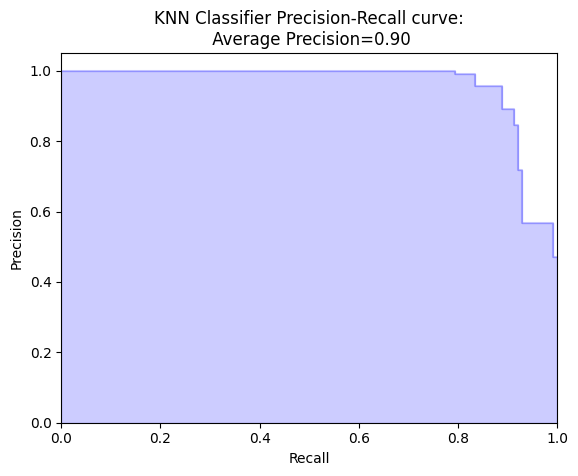

In [58]:
# Visualize the precision-recall curve

precision, recall, _ = precision_recall_curve(y_test, knn.predict_proba(x_test)[:,1])
average_precision = average_precision_score(y_test, y_pred_knn)

# Plot
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'KNN Classifier Precision-Recall curve:\n Average Precision={average_precision:.2f}')
plt.show()

## Random Forest Classifier

In [59]:
# Build a Random Forest Classifier by first tuning the hyperparameters

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=0)

# Perform a GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model with cross-validation
cv_scores = cross_val_score(best_rf_model, x_train, y_train, cv=10)
print("Cross-validated scores:", cv_scores)
print("Mean cross-validated score:", np.mean(cv_scores))

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validated accuracy: 0.933609592664433
Cross-validated scores: [0.91588785 0.95327103 0.96261682 0.93457944 0.87850467 0.92523364
 0.90654206 0.93457944 0.96261682 0.96226415]
Mean cross-validated score: 0.933609592664433


In [60]:
# Fit the model on the training data
best_rf_model.fit(x_train, y_train)

# Make predictions on the test data
y_pred_rf = best_rf_model.predict(x_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy: 0.9477611940298507
Confusion Matrix:
 [[140   2]
 [ 12 114]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       142
           1       0.98      0.90      0.94       126

    accuracy                           0.95       268
   macro avg       0.95      0.95      0.95       268
weighted avg       0.95      0.95      0.95       268



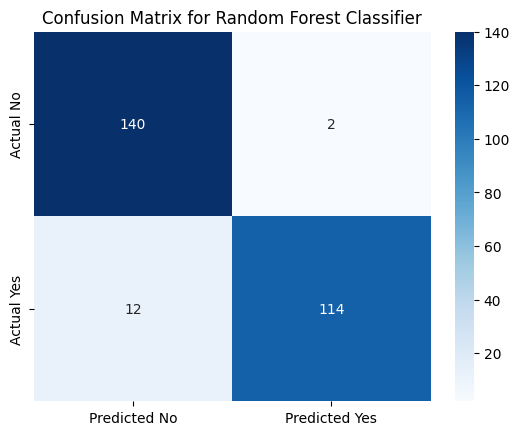

In [61]:
# Visualize the confusion matrix

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

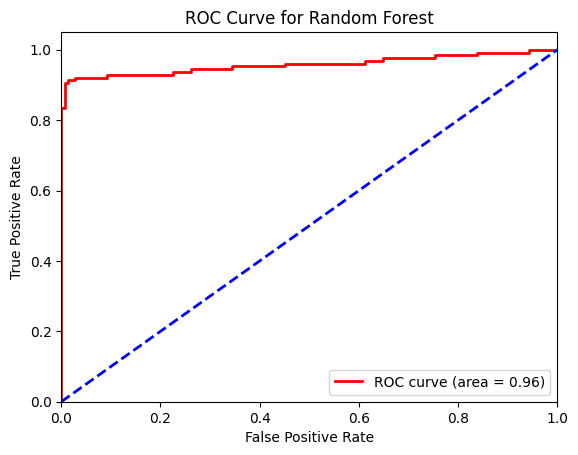

In [62]:
# Visualize the ROC curve and AUC score

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, best_rf_model.predict_proba(x_test)[:,1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the figure
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

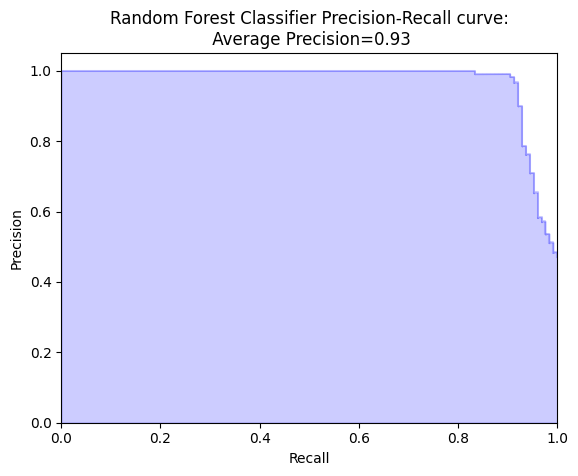

In [63]:
# Visualize the precision-recall curve

precision, recall, _ = precision_recall_curve(y_test, best_rf_model.predict_proba(x_test)[:,1])
average_precision = average_precision_score(y_test, y_pred_rf)

# Plot the figure
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Random Forest Classifier Precision-Recall curve:\n Average Precision={average_precision:.2f}')
plt.show()

<ipython-input-67-1577cfc810f1>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


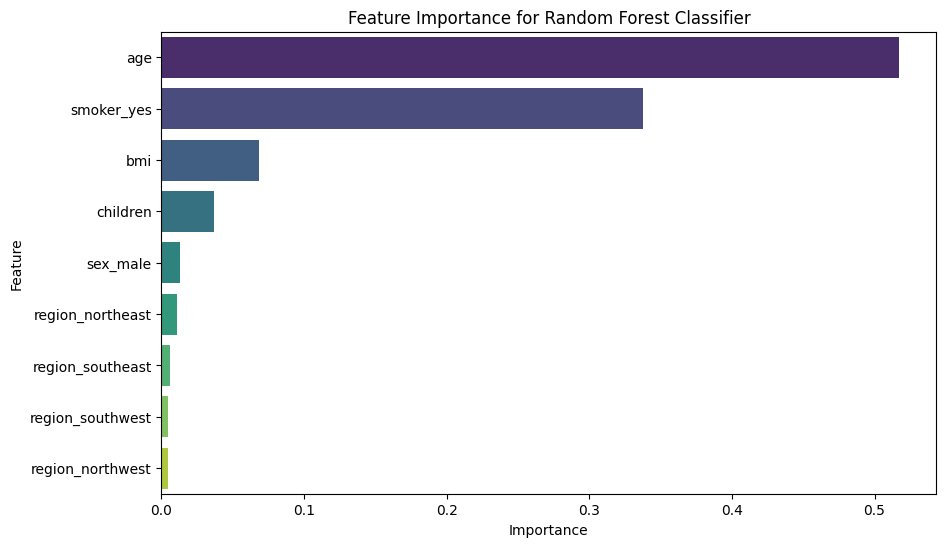

In [67]:
# Get the feature importances
feature_importances_rf = best_rf_model.feature_importances_

# Create a DataFrame to store the feature importances
importance_df_rf = pd.DataFrame({'Feature': x_columns, 'Importance': feature_importances_rf})

# Sort the DataFrame by importance
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf, palette='viridis')
plt.title('Feature Importance for Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Extreme Gradient Boosting Classifier (XGBoost)

In [68]:
# Build an XGBoost Classifier by first tuning the hyperparameters

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the XGBClassifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

# Perform a GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

# Get the best model
best_xgb_model = grid_search.best_estimator_

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validated accuracy: 0.9382736730735319


In [69]:
# Fit the model on the training data
best_xgb_model.fit(x_train, y_train)

# Make predictions on the test data
y_pred_xgb = best_xgb_model.predict(x_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

Accuracy: 0.9552238805970149
Confusion Matrix:
 [[141   1]
 [ 11 115]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       142
           1       0.99      0.91      0.95       126

    accuracy                           0.96       268
   macro avg       0.96      0.95      0.95       268
weighted avg       0.96      0.96      0.96       268



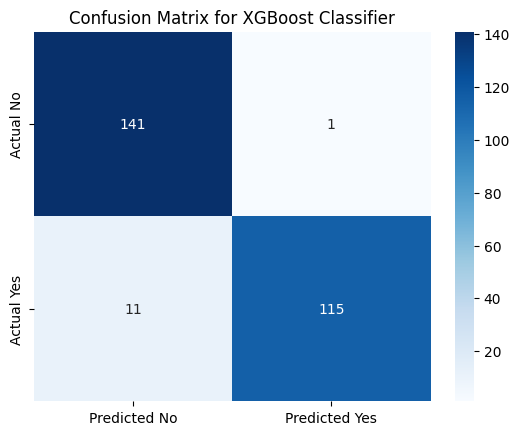

In [70]:
# Visualize the confusion matrix

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()

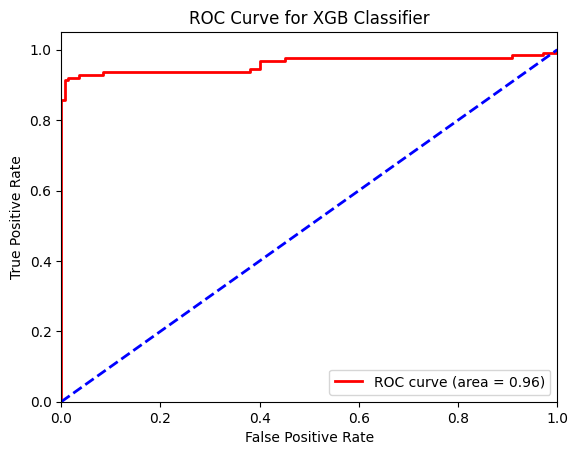

In [71]:
# Visualize the ROC Curve and AUC score

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, best_xgb_model.predict_proba(x_test)[:,1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot the figure
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGB Classifier')
plt.legend(loc="lower right")
plt.show()

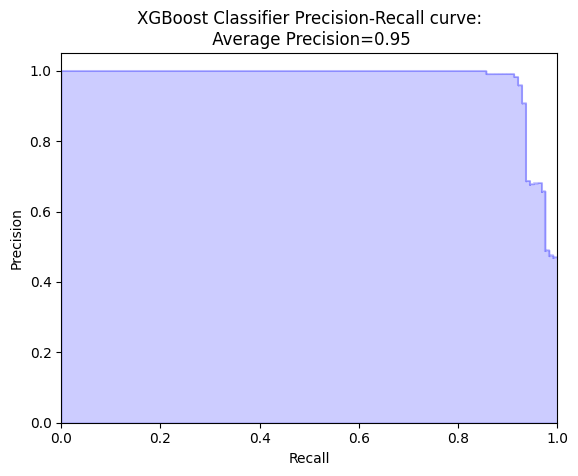

In [72]:
# Visualize the precision-recall curve

precision, recall, _ = precision_recall_curve(y_test, best_xgb_model.predict_proba(x_test)[:,1])
average_precision = average_precision_score(y_test, y_pred_xgb)

# Plot the figure
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'XGBoost Classifier Precision-Recall curve:\n Average Precision={average_precision:.2f}')
plt.show()

<ipython-input-75-9c4098bffc58>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df_xgb, palette='viridis')


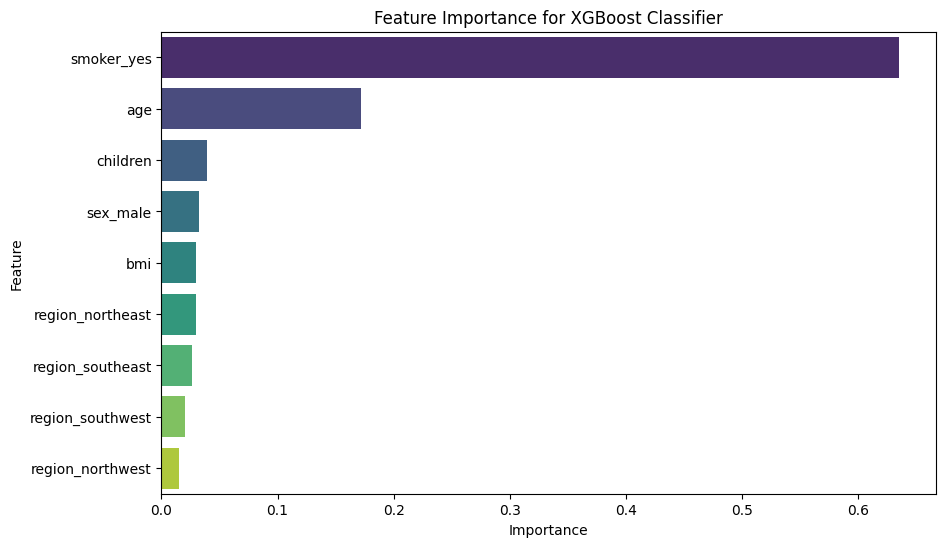

In [75]:
# Get the feature importances
importance_values_xgb = best_xgb_model.feature_importances_

# Create a DataFrame to store the feature importances
importance_df_xgb = pd.DataFrame({'Feature': x_columns, 'Importance': importance_values_xgb})

# Sort the DataFrame by importance
importance_df_xgb = importance_df_xgb.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_xgb, palette='viridis')
plt.title('Feature Importance for XGBoost Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()